# Training the SPOCK model

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt

from hadden_theory.test_particle_secular_hamiltonian import SyntheticSecularTheory, TestParticleSecularHamiltonian, calc_g0_and_s0
from hadden_theory import test_particle_secular_hamiltonian
# hack to make pickle load work
import sys
sys.modules['test_particle_secular_hamiltonian'] = test_particle_secular_hamiltonian

try:
	plt.style.use('/Users/dtamayo/.matplotlib/paper.mplstyle')
except:
	pass

/Users/kdey/.pyenv/versions/3.12.10/envs/poel/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:
import pickle
with open("hadden_theory/solar_system_synthetic_solution.bin","rb") as fi:
	solar_system_synthetic_theory=pickle.load(fi)

In [ ]:
truncate_dictionary = lambda d,tol: {key:val for key,val in d.items() if np.abs(val)>tol}
simpler_secular_theory = SyntheticSecularTheory(
	solar_system_synthetic_theory.masses,
	solar_system_synthetic_theory.semi_major_axes,
	solar_system_synthetic_theory.omega_vector,
	[truncate_dictionary(x_d,1e-3) for x_d in solar_system_synthetic_theory.x_dicts],
	[truncate_dictionary(y_d,1e-3) for y_d in solar_system_synthetic_theory.y_dicts]
)

In [ ]:
# Read the table with the defined column specifications
df = pd.read_fwf('MPCORB.DAT', colspecs=[[0,7], [8,14], [15,19], [20,25], [26,35], [36,46], [47, 57], [58,68], [69,81], [82, 91], [92, 103]])
df = df[df['Epoch'] == 'K239D'] # take only ones at common epoch--almost all of them
for c in ['a', 'e', 'Incl.', 'Node', 'Peri.', 'M']:
	df[c] = pd.to_numeric(df[c])
df.head()

,Des'n,H,G,Epoch,M,Peri.,Node,Incl.,e,n,a
1,00001,3.34,0.15,K239D,60.07879,73.42179,80.25496,10.58688,0.078913,.21410680,2.767254
2,00002,4.12,0.15,K239D,40.59806,310.87290,172.91881,34.92584,0.230229,.21377378,2.770128
3,00003,5.17,0.15,K239D,37.02310,247.73791,169.83920,12.99055,0.256213,.22600445,2.669263
4,00004,3.22,0.15,K239D,169.35183,151.66223,103.71002,7.14218,0.089449,.27152244,2.361922
5,00005,7.00,0.15,K239D,303.39802,359.13666,141.46909,5.35867,0.187439,.23826556,2.576886


evectors, ivectors
relative to the planet
add variance of a, res osc will shift sec

In [5]:
labels = pd.read_fwf('proper_catalog24.dat', colspecs=[[0,10], [10,18], [19,28], [29,37], [38, 46], [47,55], [56,66], [67,78], [79,85], [86, 89], [90, 97]], header=None, index_col=False, names=['propa', 'da', 'prope', 'de', 'propsini', 'dsini', 'g', 's', 'H', 'NumOpps', "Des'n"])
labels.head()

,propa,da,prope,de,propsini,dsini,g,s,H,NumOpps,Des'n
0,2.767028,2.300000e-05,0.115193,0.00016,0.167560,0.000013,54.253800,-59.249995,3.34,123,00001
1,2.771276,1.200000e-04,0.280234,0.00034,0.546016,0.000045,-1.372312,-46.451120,4.12,121,00002
2,2.669376,7.500000e-06,0.233600,0.00001,0.229144,0.000003,43.858531,-61.476025,5.17,114,00003
3,2.361512,5.900000e-08,0.099452,0.00014,0.111023,0.000180,36.882605,-39.610314,3.22,110,00004
4,2.577657,2.900000e-05,0.171249,0.01200,0.076113,0.001400,52.506470,-51.132322,7.00,87,00005


In [ ]:
integration_path = Path("integrations/ecc_inc_no_integration")
file_names = list(integration_path.glob("*.npz"))
rows = []

for i in range(len(file_names)):
	soln_h = np.load(file_names[i])
	prope_value = soln_h["u"]
	propsini_value = soln_h["v"]
	des_n = file_names[i].stem.replace("integration_results_", "")
	rows.append([des_n, prope_value, propsini_value])

df_h = pd.DataFrame(rows, columns=["Des'n", "prope_h", "propsini_h"])

In [7]:
merged_df = pd.merge(df, labels, on="Des'n", how="inner")
merged_df = pd.merge(merged_df, df_h, on="Des'n", how="inner")
merged_df.shape, labels.shape

((1248823, 23), (1249051, 11))

In [8]:
merged_df["g0"] = merged_df['a'].apply(lambda x: calc_g0_and_s0(x, simpler_secular_theory)[0])

In [13]:
merged_df["prope_h"] = np.abs(merged_df["prope_h"])
merged_df["propsini_h"] = np.abs(merged_df["propsini_h"])
merged_df['prope_h'] = pd.to_numeric(merged_df['prope_h'], errors='coerce')
merged_df['propsini_h'] = pd.to_numeric(merged_df['propsini_h'], errors='coerce')
merged_df['Node'] = pd.to_numeric(merged_df['Node'], errors='coerce')
merged_df['Peri.'] = pd.to_numeric(merged_df['Peri.'], errors='coerce')
merged_df['ecospo'] = merged_df['prope_h']*np.cos((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
merged_df['esinpo'] = merged_df['prope_h']*np.sin((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
merged_df['sinicosO'] = np.sin(merged_df['propsini_h']*np.pi/180)*np.cos(merged_df['Node']*np.pi/180)
merged_df['sinisinO'] = np.sin(merged_df['propsini_h']*np.pi/180)*np.sin(merged_df['Node']*np.pi/180)

In [14]:
merged_df.to_csv("merged_elements.csv")

In [2]:
merged_df = pd.read_csv("merged_elements.csv")
merged_df.columns

/var/folders/k_/p1chgts523d4tkvjb0zm_3bm0000gn/T/ipykernel_23460/3615179549.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv("merged_elements.csv")


Index(['Unnamed: 0', 'Des'n', 'H_x', 'G', 'Epoch', 'M', 'Peri.', 'Node',
       'Incl.', 'e', 'n', 'a', 'propa', 'da', 'prope', 'de', 'propsini',
       'dsini', 'g', 's', 'H_y', 'NumOpps', 'prope_h', 'propsini_h', 'g0',
       'ecospo', 'esinpo', 'sinicosO', 'sinisinO'],
      dtype='object')

In [3]:
len(merged_df)

1248823

In [4]:
#features = ['M', 'Peri.', 'Node', 'Incl.', 'e', 'a']
#features = ['M', 'Peri.', 'Node', 'Incl.', 'e', 'propa']
#features = ['M', 'Node', 'Incl.', 'ecospo', 'esinpo', 'propa']
features = ['sinicosO', 'sinisinO', 'ecospo', 'esinpo', 'propa', 'g0', 'prope_h']
data = merged_df[features]
dela = merged_df['propa']-merged_df['a']
dele = merged_df['prope']-merged_df['e']
delsini = merged_df['propsini']-np.sin(merged_df['Incl.']*np.pi/180)
delg = merged_df['g0'] - merged_df['g']
s = merged_df['s']

(0.0, 0.5)

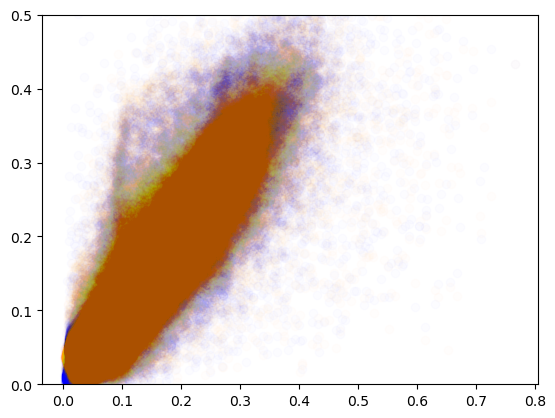

In [6]:
plt.scatter(merged_df['prope'], merged_df['prope_h'], alpha=0.01, color = "blue")
plt.scatter(merged_df['prope'], merged_df['e'], alpha=0.01, color = "orange")
plt.ylim(0, 0.5)

/tmp/ipykernel_57293/1763704731.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_y, x_y, 'k--', linewidth=1, label='y = x', color = "white")
/tmp/ipykernel_57293/1763704731.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_y, x_y, 'k--', linewidth=1, label='y = x', color = "white")


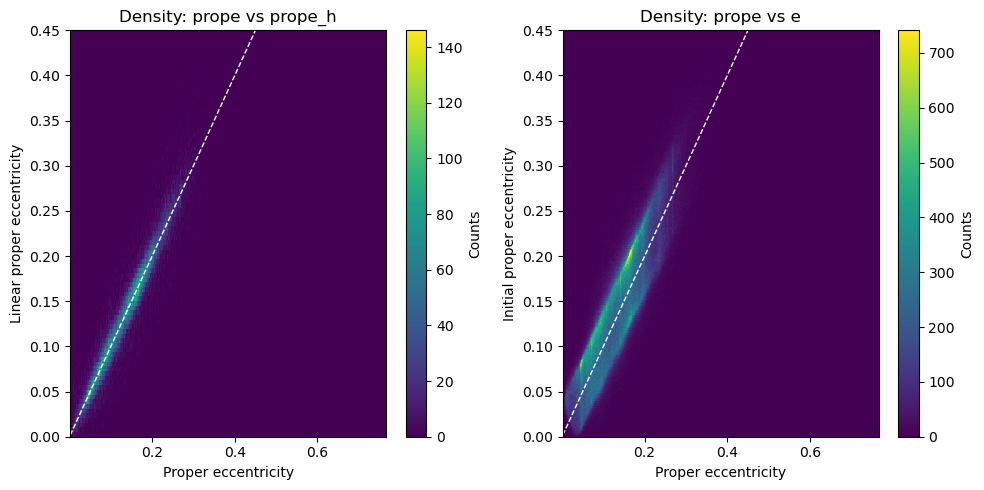

In [7]:
plt.figure(figsize=(10, 5))
x_y = np.linspace(0, 0.45, 10000)
# Density for prope vs prope_h
plt.subplot(1, 2, 1)
plt.hist2d(merged_df['prope'], merged_df['prope_h'], bins=10000, norm=plt.Normalize(), rasterized=True)
plt.plot(x_y, x_y, 'k--', linewidth=1, label='y = x', color = "white")
plt.colorbar(label='Counts')
plt.ylim(0, 0.45)
plt.xlabel('Proper eccentricity')
plt.ylabel('Linear proper eccentricity')
plt.title('Density: prope vs prope_h')

# Density for prope vs e
plt.subplot(1, 2, 2)
plt.hist2d(merged_df['prope'], merged_df['e'], bins=300, norm=plt.Normalize(), rasterized=True)
plt.plot(x_y, x_y, 'k--', linewidth=1, label='y = x', color = "white")
plt.colorbar(label='Counts')
plt.ylim(0, 0.45)
plt.xlabel('Proper eccentricity')
plt.ylabel('Initial proper eccentricity')
plt.title('Density: prope vs e')

plt.tight_layout()
plt.show()


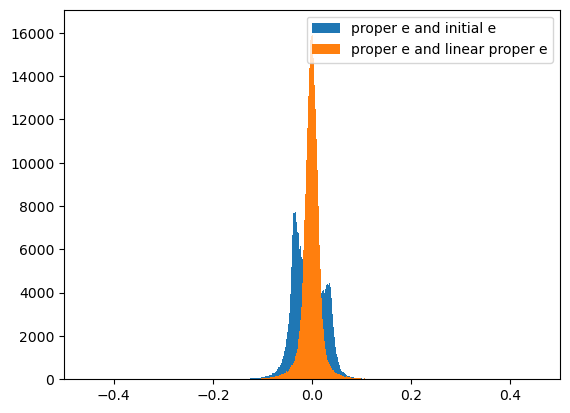

In [17]:
bins = np.linspace(-0.2, 0.2, 1000)
plt.hist(merged_df['prope']-merged_df['e'], bins=bins, label = "proper e and initial e")
plt.hist(merged_df['prope']-merged_df['prope_h'], bins=bins, label = 'proper e and linear proper e')
plt.xlim(-0.5, 0.5)
plt.legend()
plt.show()

# NGBooster training

In [ ]:
from ngboost import NGBRegressor
from ngboost.distns import Normal
from ngboost.scores import LogScore
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import time
from sklearn.tree import DecisionTreeRegressor

trainX, testX, trainY, testY = train_test_split(data, dele, test_size=0.2, random_state=42)
space = {
	'max_depth': hp.choice('max_depth', [2, 3, 4]),
	'minibatch_frac': hp.choice('minibatch_frac', [1.0, 0.5]),
	'learning_rate': hp.choice('learning_rate', [0.01, 0.05, 0.1])
}

def objective(params):
	clf = NGBRegressor(
		Dist=Normal,
		Score=LogScore,
		verbose=False,
		minibatch_frac=params['minibatch_frac'],
		n_estimators=200,
		learning_rate=params['learning_rate'],
		Base=DecisionTreeRegressor(max_depth=int(params['max_depth']))
	)
	
	clf.fit(trainX, trainY)    
	preds = clf.pred_dist(testX)
	mu = preds.loc
	rmse = np.sqrt(np.mean((testY-mu)**2))

	return {'loss': rmse, 'status': STATUS_OK}

trials = Trials()
start = time.time()

best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 10, trials = trials, rstate=np.random.default_rng(seed=0))
end = time.time()
print("Best hyperparameters:", best)
print("Optimization Time: %.2f seconds" % (end - start))

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/miniconda3/envs/lshen/lib/python3.12/site-packages/ngboost/distns/normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2

/home/miniconda3/envs/lshen/lib/python3.12/site-packages/ngboost/distns/normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])

/home/miniconda3/envs/lshen/lib/python3.12/site-packages/ngboost/distns/normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2

/home/miniconda3/envs/lshen/lib/python3.12/site-packages/ngboost/distns/normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])

/home/miniconda3/envs/lshen/lib/python3.12/site-packages/ngboost/distns/normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2



  0%|          | 0/10 [09:50<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # graphics card
device = torch.device("mps" if torch.mps.is_available() else "cpu") # macos
print(device)

mps


In [ ]:
class MultiOutputNN(nn.Module):
	def __init__(self, input_dim):
		super().__init__()
		activation = nn.Tanh
		self.f = nn.Sequential(
			nn.Linear(input_dim, 10),
			activation(),
			nn.Linear(10, 15),
			activation(),
			nn.Linear(15, 8),
			activation(),
			nn.Linear(8, 4),
			activation(), 
			nn.Linear(4, 2),
			activation(), 
		)
		# self.f = nn.Sequential(
		# 	nn.Linear(input_dim, 4),
		# 	activation(), 
		# 	nn.Linear(4, 2),
		# 	activation()
		# )

	def forward(self, x):
		return self.f(x)

class MultiOutputML:
	"""
	Neural Network learning model to predict the proper elements from osculating and linear proper 
	elements derived from Nesvorny 2024 paper
	"""

	def __init__(self, device):
		self.model = None
		self.device = device
		self.random_state = 42
		self.best_params = None


	def combined_loss(self, outputs, true_proper, kl_weight=0.05, mse_weight=1.0):
		mean_pred = outputs[:, 0]
		log_std_pred = outputs[:, 1]
		std_pred = torch.exp(log_std_pred)/10

		true_std = 0.1
		true_mean = 0.0

		# KL Divergence
		kl_div = (
			torch.log(true_std / std_pred) +
			(std_pred**2 + (mean_pred - true_mean)**2) / (2 * true_std**2) -
			0.5
		)
		kl_loss = kl_div.mean()

		# Sample from predicted distribution and compute RMSE
		e_proper_guess = mean_pred + torch.randn_like(std_pred) * std_pred
		# mse_loss = ((e_proper_guess - true_proper)**2).mean()
		mse_loss = torch.nn.L1Loss()(e_proper_guess, true_proper)

		return kl_weight * kl_loss + mse_weight * mse_loss

	# def objective(self, params):
	# 	input_dim = self.trainX.shape[1]
	# 	model = MultiOutputNN(input_dim).to(self.device)
	# 	optimizer = optim.Adam(model.parameters(), lr=0.001)
	# 	loss_func = self.combined_loss

	# 	X_train_tensor = torch.tensor(self.X, dtype=torch.float32).to(self.device)
	# 	y_train_tensor = torch.tensor(self.y, dtype=torch.float32).to(self.device)
	# 	for epoch in range(100):
	# 		model.train()
	# 		optimizer.zero_grad()
	# 		outputs = model(X_train_tensor)
	# 		loss = loss_func(outputs, y_train_tensor)
	# 		loss.backward()
	# 		optimizer.step()

	# 	# Evaluation
	# 	model.eval()
	# 	with torch.no_grad():
	# 		X_test_tensor = torch.tensor(self.testX, dtype=torch.float32).to(self.device)
	# 		y_test_tensor = torch.tensor(self.testy, dtype=torch.float32).to(self.device)
	# 		pred = model(X_test_tensor)
	# 		test_loss = loss_func(pred, y_test_tensor).item()

	# 	return {'loss': test_loss, 'status': STATUS_OK}
	
	# def optimize_hyperparameters(self, X, y, max_evals=10):
	# 	# self.trainX, self.testX, self.trainy, self.testy = train_test_split(
	# 	# 	X, y, test_size=0.2, random_state=self.random_state
	# 	# )
	# 	trials = Trials()
	# 	import time
	# 	start = time.time()
	# 	self.best = fmin(
	# 		fn=self.objective,
	# 		space=self.space,
	# 		algo=tpe.suggest,
	# 		max_evals=max_evals,
	# 		trials=trials,
	# 		rstate=np.random.default_rng(self.random_state)
	# 	)
	# 	end = time.time()
	# 	print("Optimization Time: %f seconds", (end  -start))

	def training(self, X, y, epochs=300, batch_size=64, lr=0.001):
		self.X = X
		self.y = y

		input_dim = X.shape[1]
		self.model = MultiOutputNN(input_dim).to(self.device)
		optimizer = optim.Adam(self.model.parameters(), lr=lr)
		criterion = self.combined_loss

		X_tensor = torch.tensor(X, dtype=torch.float32)
		y_tensor = torch.tensor(y, dtype=torch.float32)

		dataset = TensorDataset(X_tensor, y_tensor)
		training_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

		self.loss_list = []

		for epoch in tqdm(range(epochs), desc="Training"):
			self.model.train()
			epoch_loss = 0

			for batch_X, batch_y in training_loader:
				batch_X = batch_X.to(self.device)
				batch_y = batch_y.to(self.device)

				optimizer.zero_grad()
				outputs = self.model(batch_X)
				loss = criterion(outputs, batch_y)
				loss.backward()
				optimizer.step()

				epoch_loss += loss.item()

			avg_loss = epoch_loss / len(training_loader)
			self.loss_list.append(avg_loss)

		return self.loss_list, self.model

	def predict(self, X):
		self.model.eval()
		with torch.no_grad():
			X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
			pred = self.model(X_tensor).cpu().numpy()
			pred_mean = pred[:, 0]
			pred_std = np.exp(pred[:, 1])/10
			return pred_mean, pred_std


In [8]:
trainX, testX, trainY, testY = train_test_split(data, dele, test_size=0.4, random_state=42)
scalar = StandardScaler()
scalar.fit_transform(trainX)
trainX = scalar.transform(trainX)
testX = scalar.transform(testX)

In [10]:
model = MultiOutputML(device)
loss_list, trained_model = model.training(trainX, trainY.to_numpy(), batch_size=2048*64)

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Training: 100%|██████████| 300/300 [17:53<00:00,  3.58s/it]


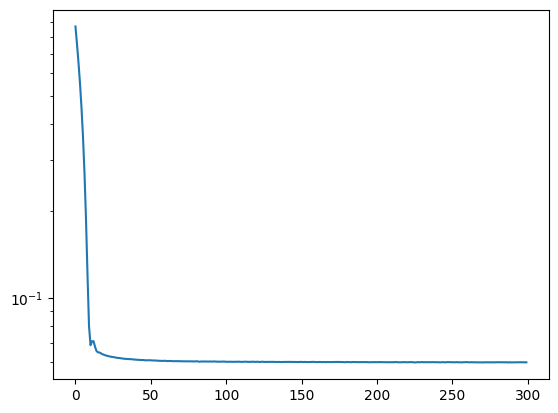

In [11]:
plt.semilogy(model.loss_list)

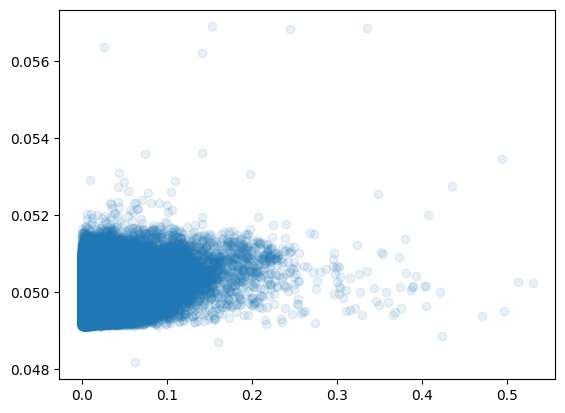

In [12]:
pred, std = model.predict(testX)
plt.scatter(np.abs(testY - pred), std, alpha=0.1)

In [17]:
pred

array([-0.00836096,  0.01456548, -0.02281791, ...,  0.00335555,
        0.03355795, -0.01788718], dtype=float32)

In [28]:
import itertools
import numpy as np

FN_list = [] # Do not need to integrate but predict as need to integrate
FP_list = [] # Need to integrate but predict as don't need to integrate
TN_list = [] # Do not need to integrate and predict as need to integrate
TP_list = [] # Need to integrate and predict as need to integrate

actual_thresholds = 0.05
pred_thresholds = np.linspace(0, 0.2, 1000)
actual_val = testY.to_numpy()

tpr = []
fpr = []

for pred_thres in tqdm(pred_thresholds):
	FN = FP = TN = TP = 0

	percentage_error = np.abs(actual_val- pred) / (np.abs(actual_val) + 1e-8)

	pct_err_gt_thresh = percentage_error > actual_thresholds
	std_gt_pred_thresh = std > pred_thres

	TP = (pct_err_gt_thresh & std_gt_pred_thresh).sum()
	FP = ((~pct_err_gt_thresh) & std_gt_pred_thresh).sum()
	FN = (pct_err_gt_thresh & (~std_gt_pred_thresh)).sum()
	TN = ((~pct_err_gt_thresh) & (~std_gt_pred_thresh)).sum()
	
	if (TP + FN) > 0 and (FP + TN) > 0:
		tpr.append(TP / (TP + FN))
		fpr.append(FP / (FP + TN))


100%|██████████| 1000/1000 [00:01<00:00, 513.32it/s]


In [29]:
fpr = np.array(fpr)
tpr = np.array(tpr)
sorted_indices = np.argsort(fpr)
fpr = fpr[sorted_indices]
tpr = tpr[sorted_indices]

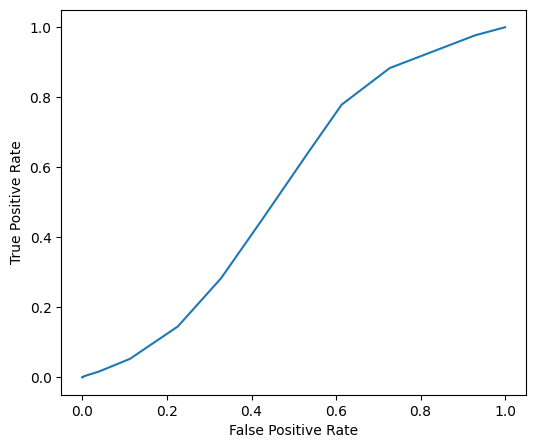

In [30]:
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [27]:
from sklearn.metrics import auc
auc_score = auc(fpr, tpr)
print(f"the AUC score is {auc_score}")

the AUC score is 0.539865214137008


## Tuning hyperparameter
We will start by creating and testing a collection of models that have randomly selected hyperparameters.
We establish the different parameter space that we will be testing different hyperparameter values within.

We can now run an array of different parameter combinations

NameError: name 'score' is not defined

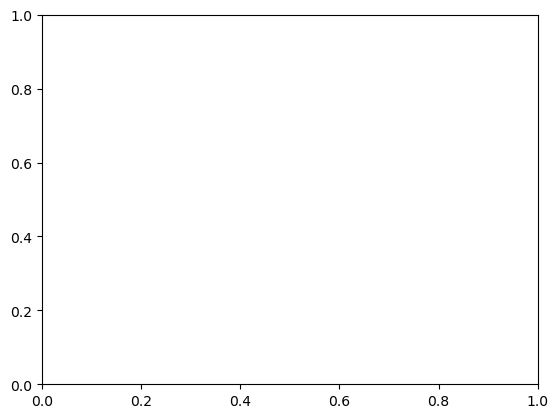

In [12]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

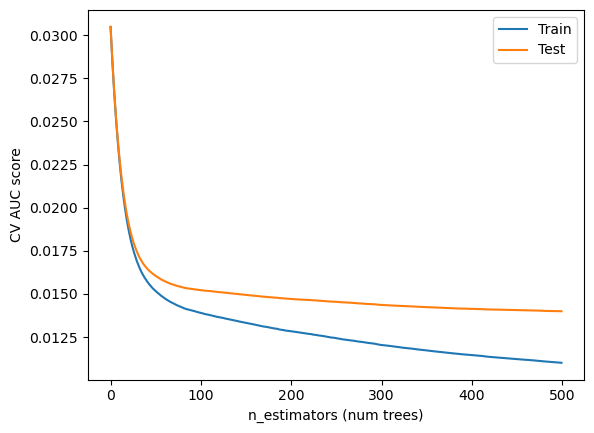

In [22]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

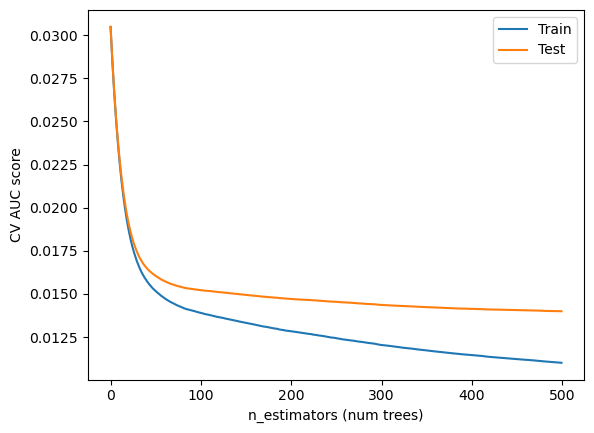

In [23]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

In [57]:
#model.set_params(n_estimators = 10, max_depth = int(best['x_max_depth']), subsample = best['x_subsample'], min_child_weight = best['x_min_child'])
model= xgb.train(dtrain=dtrain, params=model.get_params(), num_boost_round=2000)

AttributeError: 'Booster' object has no attribute 'get_params'

In [25]:
%%time
pred = model.predict(dtest)

CPU times: user 34.4 ms, sys: 1.11 ms, total: 35.5 ms
Wall time: 1.1 ms


In [26]:
np.std(pred-testY)

0.013482646046591199

NameError: name 'labels' is not defined

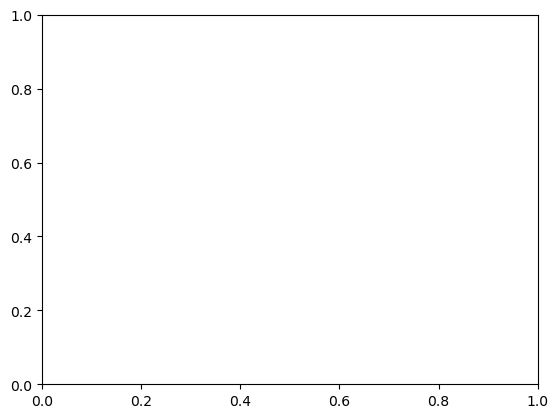

In [32]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(labels['prope'], bins=np.linspace(0, 1, 1000))
ax.set_xlabel('Prop e')

Text(0.5, 0, 'Nesvorny Proper Eccentricity Correction')

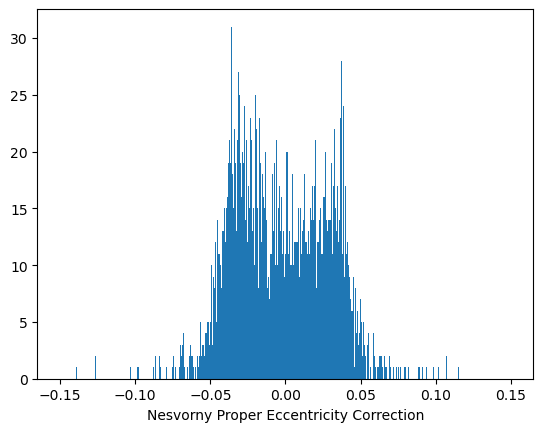

In [28]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(testY, bins=np.linspace(-0.15, 0.15, 1000))
ax.set_xlabel('Nesvorny Proper Eccentricity Correction')

Text(0.5, 0, 'Correction Error (Model-Nesvorny)')

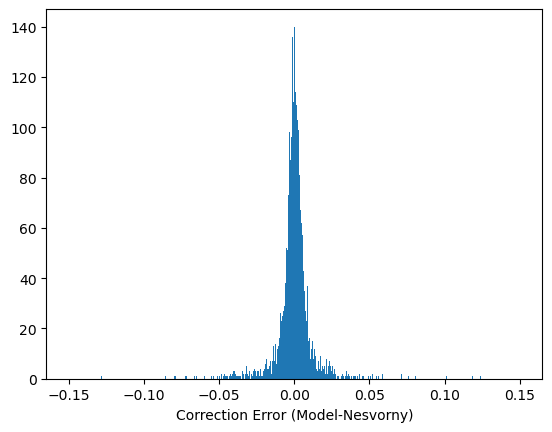

In [ ]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.15, 0.15, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')


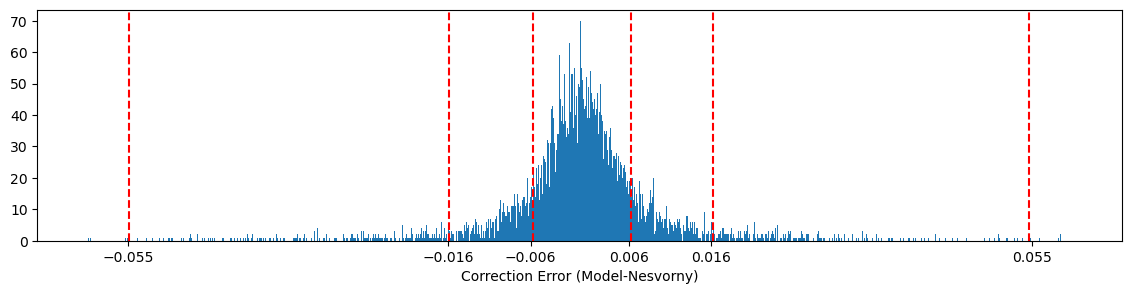

In [ ]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
	val = np.percentile(pred-testY, p)
	ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

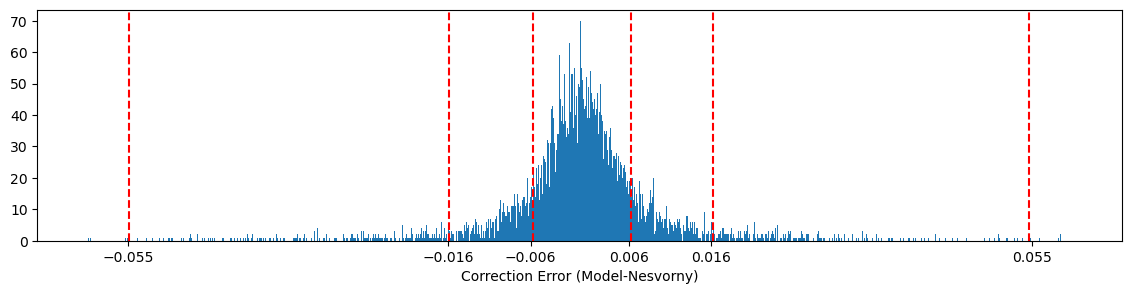

In [ ]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
	val = np.percentile(pred-testY, p)
	ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

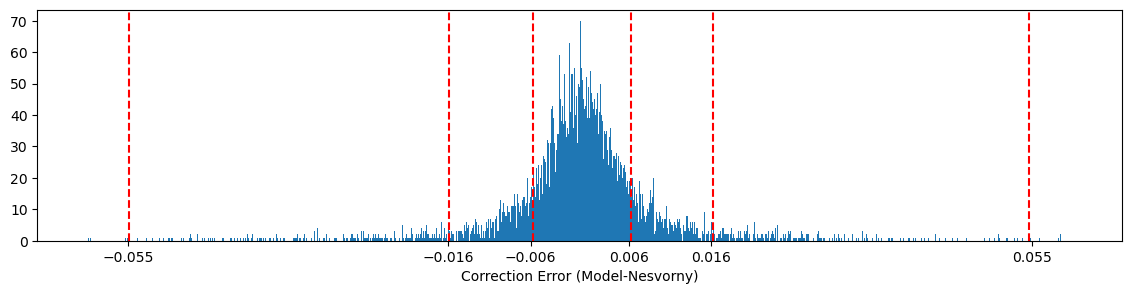

In [ ]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
	val = np.percentile(pred-testY, p)
	ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

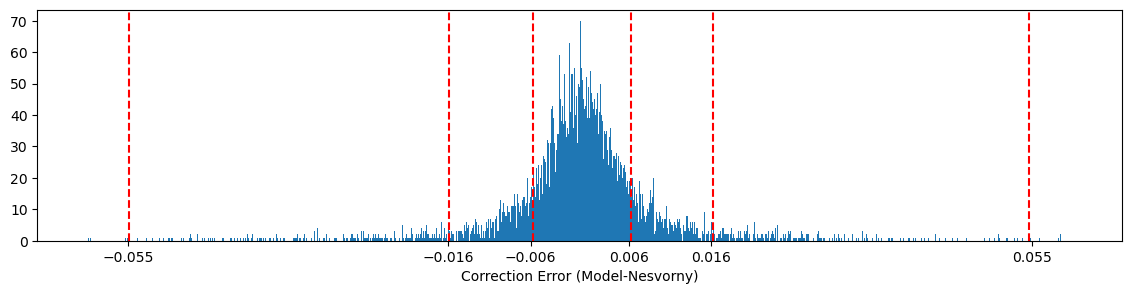

In [ ]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
	val = np.percentile(pred-testY, p)
	ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

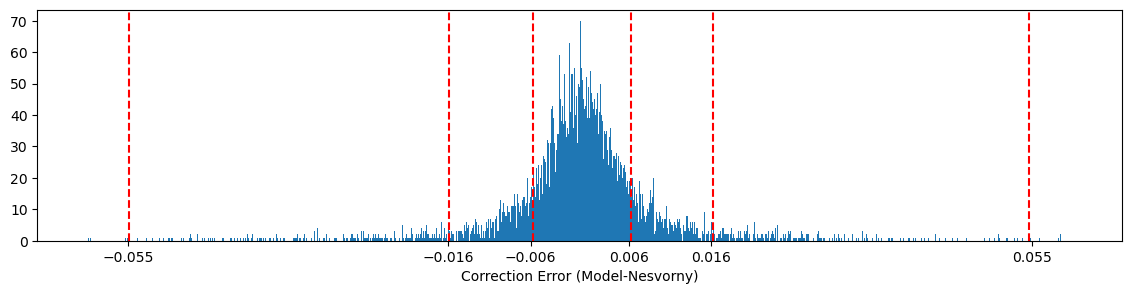

In [ ]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
	val = np.percentile(pred-testY, p)
	ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

In [26]:
(pred-testY).min()

NameError: name 'pred' is not defined

# RMS Comparison

In [ ]:
test_indices = testY.index
e_nesvorny_test = merged_df.loc[test_indices, 'prope']
e_initial_test = merged_df.loc[test_indices, 'e']
e_linear_test = merged_df.loc[test_indices, 'prope_h']

rms_nesvorny_vs_initial = np.sqrt(np.median((e_nesvorny_test - e_initial_test)**2))
rms_nesvorny_vs_linear = np. sqrt(np.median((e_nesvorny_test - e_linear_test)**2))
rms_nesvorny_vs_nn=np.sqrt(np.median((testY-pred)**2))
# rms_nesvorny_vs_ml_xg=np.sqrt(np.median((testY-pred1)**2))
improvement_linear_vs_initial = ((rms_nesvorny_vs_initial - rms_nesvorny_vs_linear) / rms_nesvorny_vs_initial) * 100
improvement_nn_vs_initial = ((rms_nesvorny_vs_initial - rms_nesvorny_vs_nn) / rms_nesvorny_vs_initial) * 100
improvement_nn_vs_linear = ((rms_nesvorny_vs_linear - rms_nesvorny_vs_nn) / rms_nesvorny_vs_linear) * 100
results = {
	'rms_nesvorny_vs_initial': rms_nesvorny_vs_initial,
	'rms_nesvorny_vs_linear': rms_nesvorny_vs_linear,
	'rms_nesvorny_vs_nn': rms_nesvorny_vs_nn,
	# 'rms_nesvorny_vs_ml_xgboost': rms_nesvorny_vs_ml_xg,
	'improvement_linear_vs_initial_percent': improvement_linear_vs_initial,
	'improvement_ml_vs_initial_percent': improvement_nn_vs_initial,
	'improvement_ml_vs_linear_percent': improvement_nn_vs_linear
}
results

{'rms_nesvorny_vs_initial': 0.02637040005479629,
 'rms_nesvorny_vs_linear': 0.007955348862825923,
 'rms_nesvorny_vs_nn': 0.010621320013452505,
 'improvement_linear_vs_initial_percent': 69.8322784398601,
 'improvement_ml_vs_initial_percent': 59.722567760132705,
 'improvement_ml_vs_linear_percent': -33.511681217202685}

In [80]:
np.percentile(np.abs(error_linear), [1, 50, 75])

array([0.00015321, 0.0087313 , 0.015759  ])

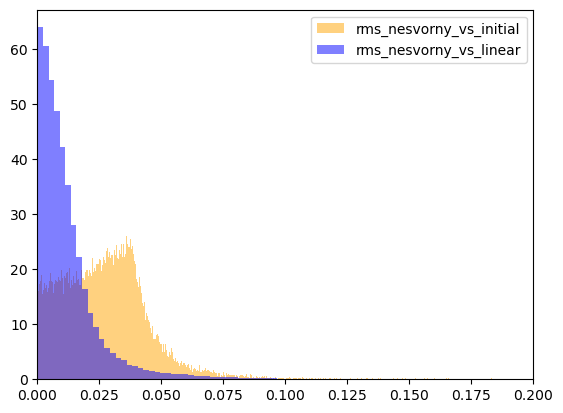

In [104]:
error_initial = np.sqrt((e_nesvorny_test - e_initial_test)**2)
error_linear = np.sqrt((e_nesvorny_test - e_linear_test)**2)
plt.hist(error_initial, bins=10000, alpha=0.5, label='rms_nesvorny_vs_initial', color = "orange", density = True)
plt.hist(error_linear, bins=10000, alpha=0.5, label='rms_nesvorny_vs_linear', color = "blue", density = True)
plt.xlim(0, 0.2)
plt.legend()

# Plots generation

In [105]:
error_threshold = 0.1
ratio = (error_linear/error_initial) * 100
high_error_mask = error_linear > error_threshold
high_error_asteroids = merged_df.loc[error_linear[high_error_mask].index]
high_error_asteroids

,Des'n,H_x,G,Epoch,M,Peri.,Node,Incl.,e,n,...,H_y,NumOpps,prope_h,propsini_h,g0,ecospo,esinpo,sinicosO,sinisinO,d
442963,j3883,17.35,0.15,K239D,309.93400,302.26164,43.71592,19.39222,0.226325,.22707162,...,17.35,8,0.414569,0.164840,0.000040,0.402215,-0.100451,0.002079,0.001988,4.491291
626871,K00Y37T,17.52,0.15,K239D,88.64204,184.55448,266.68452,5.49849,0.283645,.22700437,...,17.52,6,0.627834,0.048879,0.000040,-0.013576,0.627687,-0.000049,-0.000852,5.599039
797158,K12V08L,17.06,0.15,K239D,306.40733,259.52288,213.68039,23.63686,0.329564,.17776291,...,17.06,7,0.344486,0.200795,0.000068,-0.135725,0.316621,-0.002916,-0.001943,107.942032
407527,f7394,18.15,0.15,K239D,106.30453,22.07547,193.46948,9.66703,0.045279,.29961707,...,18.15,13,0.108629,0.087280,0.000025,-0.088387,-0.063150,-0.001481,-0.000355,2408.529276
1069236,K17W11O,18.55,0.15,K239D,159.89888,195.14683,195.44726,37.89444,0.344762,.23284566,...,18.55,2,0.310354,0.314721,0.000039,0.267151,0.157956,-0.005294,-0.001463,352.796882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71684,73441,15.59,0.15,K239D,285.05544,201.49119,182.85780,18.88909,0.062183,.23921902,...,15.59,16,0.026046,0.163937,0.000037,0.023729,0.010739,-0.002858,-0.000143,2.420354
710400,K08X07T,17.6,0.15,K239D,167.48964,58.90979,53.02019,30.54632,0.356169,.23649439,...,17.60,4,0.377466,0.254218,0.000037,-0.140974,0.350153,0.002669,0.003544,290.081985
1233300,K23D02Y,19.62,0.15,K239D,74.34882,74.37825,16.99071,26.60200,0.495586,.23657625,...,19.62,1,0.512065,0.214111,0.000037,-0.012234,0.511919,0.003574,0.001092,2903.780024
405998,f5802,17.62,0.15,K239D,341.55521,231.79016,58.88604,43.37752,0.331630,.31048486,...,17.62,7,0.293533,0.373440,0.000024,0.103643,-0.274627,0.003368,0.005580,446.741394


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

a_jupiter = 5.204
a_mars = 1.524

resonances = {
	"3:1": ("Jupiter", 3, 1),
	"12:5": ("Jupiter", 12, 5),
	"13:5": ("Jupiter", 13, 5),
	"9:4": ("Jupiter", 9, 4),
	"11:5": ("Jupiter", 11, 5),
	"2:1": ("Jupiter", 2, 1),
	"1:2": ("Mars", 1, 2),
	"7:2": ("Jupiter", 7, 2),
	"4:7": ("Mars", 4, 7)
}

# Function to calculate semi-major axis for a resonance
def compute_resonance_axis(p, q, a_primary):
	return a_primary * (q / p) ** (2/3)

# Store results
a_values = {}
for label, (planet, p, q) in resonances.items():
	if planet == "Jupiter":
		a = compute_resonance_axis(p, q, a_jupiter)
		a_values[label] = a
	else:
		a = compute_resonance_axis(p, q, a_mars)
		a_values[label] = a
a_values["5:2:2"] = 3.17

In [ ]:
# Define sample with high errors
import math

def calculate_d(a_p, delta_a_p, delta_e_p, delta_sin_i_p):
	numerator = 3e4  # 3 × 10^4 m/s
	denominator = math.sqrt(a_p)
	term1 = (delta_a_p / a_p) ** 2
	term2 = 2 * (delta_e_p ** 2)
	term3 = 2 * (delta_sin_i_p ** 2)
	inside_sqrt = (5 / 4) * term1 + term2 + term3
	d = (numerator / denominator) * math.sqrt(inside_sqrt)
	return d

merged_df['d'] = merged_df.apply(lambda row: calculate_d(row['propa'], row['da'], row['de'], row['dsini']), axis = 1)

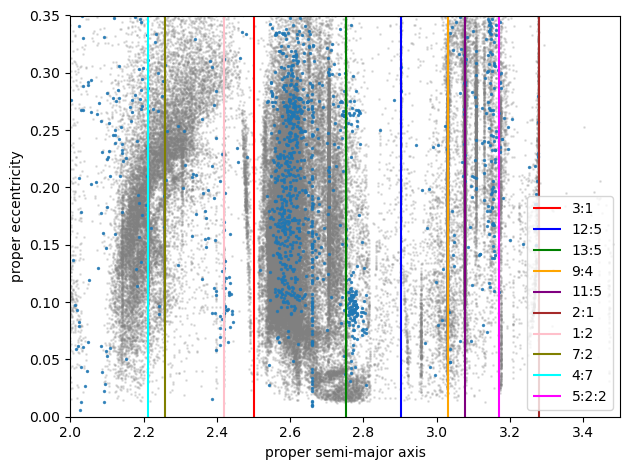

In [ ]:
colors = [
	"red", "blue", "green", "orange", "purple", "brown",
	"pink", "olive", "cyan", "magenta"
]
merged_df_high = merged_df[merged_df['d'] > 100]
linear_prop_e = merged_df_high['prope']
a = merged_df_high['propa']
plt.scatter(a, linear_prop_e, s = 1, alpha = 0.2, color = "grey")
plt.scatter(high_error_asteroids['propa'], high_error_asteroids['prope'], alpha = 0.8, s = 2)
for (label, a_val), color in zip(a_values.items(), colors):
	plt.vlines(a_val, 0, 0.35, label = label, color = color)
plt.ylim(0, 0.35)
plt.xlim(2, 3.5)
plt.xlabel("proper semi-major axis")
plt.ylabel("proper eccentricity")
plt.legend()
plt.tight_layout()
plt.show()

In [81]:
list(merged_df)

["Des'n",
 'H_x',
 'G',
 'Epoch',
 'M',
 'Peri.',
 'Node',
 'Incl.',
 'e',
 'n',
 'a',
 'propa',
 'da',
 'prope',
 'de',
 'propsini',
 'dsini',
 'g',
 's',
 'H_y',
 'NumOpps',
 'prope_h',
 'propsini_h',
 'g0',
 'ecospo',
 'esinpo',
 'sinicosO',
 'sinisinO',
 'd']

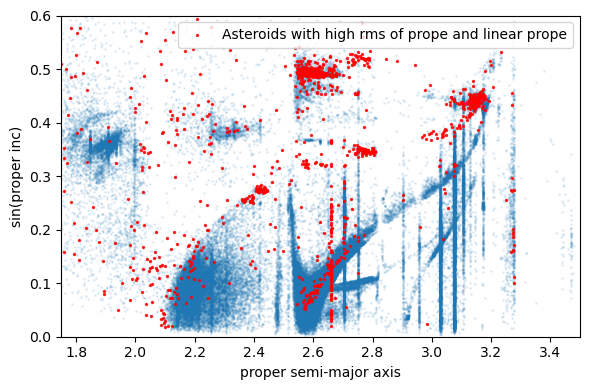

In [117]:
merged_df_high = merged_df[merged_df['d'] > 100]
linear_prop_inc = np.sin(merged_df_high['propsini'])
a = merged_df_high['propa']
plt.figure(figsize = [6, 4])
plt.scatter(a, linear_prop_inc, s = 1, alpha = 0.1)
plt.scatter(high_error_asteroids['propa'], np.sin(high_error_asteroids['propsini']), color = 'red', alpha = 0.8, s = 2, label = "Asteroids with high rms of prope and linear prope", rasterized=True)
plt.ylim(0, 0.6)
plt.xlim(1.75, 3.5)
# for (label, a_val), color in zip(a_values.items(), colors):
#     plt.vlines(a_val, 0, 0.3, label = label, color = color)
plt.xlabel("proper semi-major axis")
plt.ylabel("sin(proper inc)")
plt.legend()
plt.tight_layout()
plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_188661/2876374596.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("$\sqrt{e^2 + (sin (i))^2}$", size = 17)


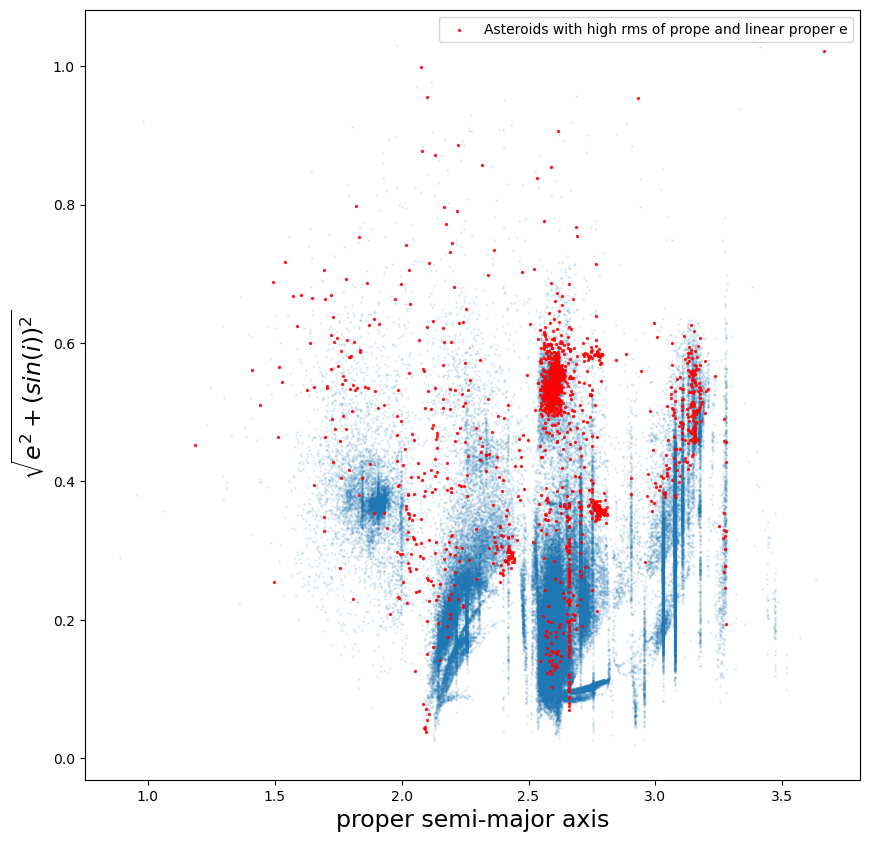

In [137]:
merged_df_high = merged_df[merged_df['d'] > 100]
para_e_inc = np.sqrt(np.sin(merged_df_high['propsini'])**2 + merged_df_high['prope']**2)
a = merged_df_high['propa']
plt.figure(figsize=[10, 10])
plt. scatter(a, para_e_inc, s = 1, alpha = 0.1)
plt.scatter(high_error_asteroids['propa'], np.sqrt(np.sin(high_error_asteroids['propsini'])**2 + high_error_asteroids['prope']**2), color = 'red', alpha = 0.8, s = 2, label = "Asteroids with high rms of prope and linear proper e")
# plt.ylim(0, 0.3)
# plt.xlim(1.75, 3.5)
# for (label, a_val), color in zip(a_values.items(), colors):
#     plt.vlines(a_val, 0, 0.3, label = label, color = color)
plt.xlabel("proper semi-major axis", size = 17)
plt.ylabel("$\sqrt{e^2 + (sin (i))^2}$", size = 17)
plt.legend()
plt.tight_layout
plt.show()

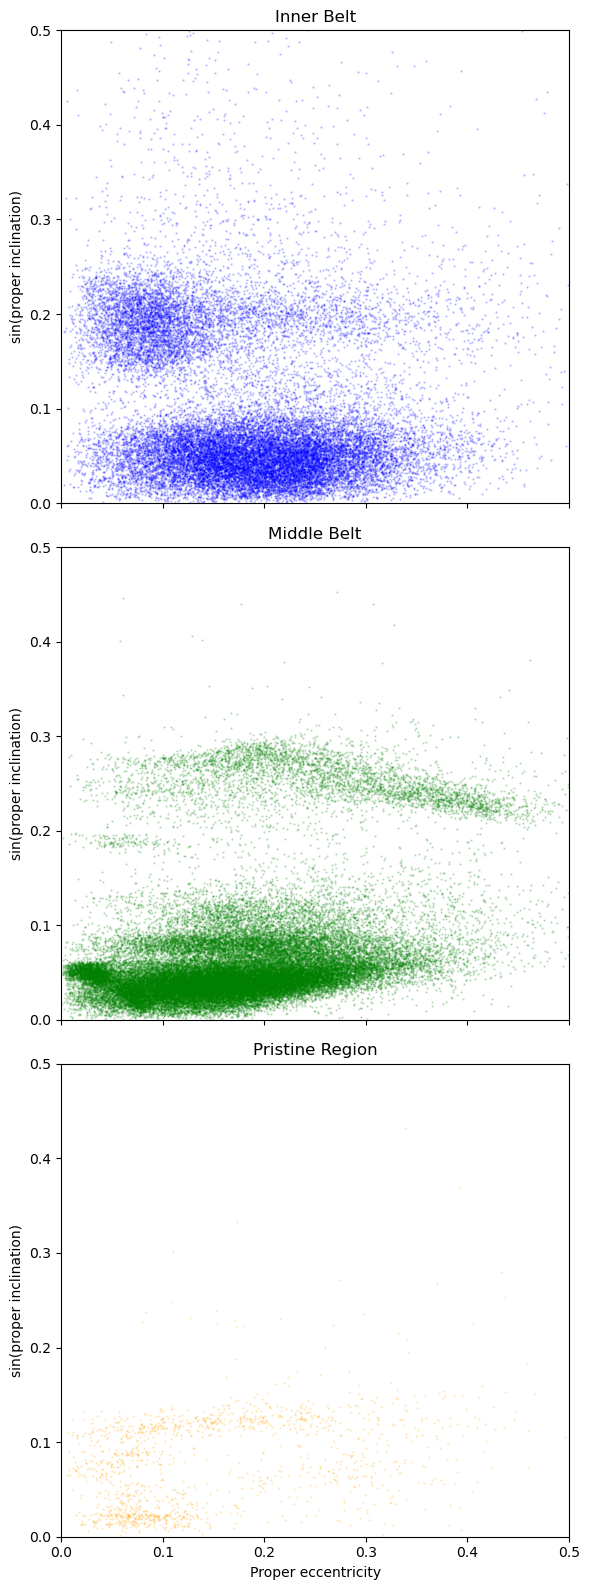

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

inner_belt_df = merged_df_high[merged_df_high["propa"] < 2.5]
middle_belt_df = merged_df_high[(merged_df_high["propa"] > 2.5) & (merged_df_high["propa"] < 2.825)]
pristine_df = merged_df_high[(merged_df_high["propa"] > 2.825) & (merged_df_high["propa"] < 2.958)]

fig, ax = plt.subplots(3, 1, figsize=(6, 16), sharex=True, sharey=True)

# Inner belt
linear_sin_i_inner = np.sin(inner_belt_df['propsini_h'])
linear_prope_inner = inner_belt_df["prope_h"]
ax[0].scatter(linear_prope_inner, linear_sin_i_inner, s=0.5, alpha=0.2, color='blue')
ax[0].set_title("Inner Belt")

# Middle belt
linear_sin_i_middle = np.sin(middle_belt_df['propsini_h'])
linear_prope_middle = middle_belt_df["prope_h"]
ax[1].scatter(linear_prope_middle, linear_sin_i_middle, s=0.5, alpha=0.2, color='green')
ax[1].set_title("Middle Belt")

# Pristine region
linear_sin_i_pristine = np.sin(pristine_df['propsini_h'])
linear_prope_pristine = pristine_df["prope_h"]
ax[2].scatter(linear_prope_pristine, linear_sin_i_pristine, s=0.5, alpha=0.2, color='orange')
ax[2].set_title("Pristine Region")

for axis in ax:
	axis.set_xlim(0, 0.5)
	axis.set_ylim(0, 0.5)
	axis.set_ylabel("sin(proper inclination)")

ax[2].set_xlabel("Proper eccentricity")

plt.tight_layout()
plt.show()

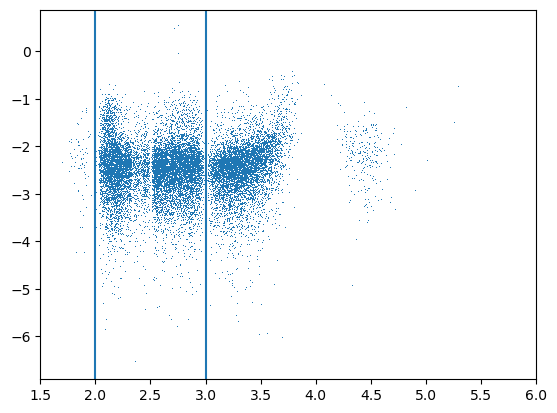

In [ ]:
aJup = 5.202263784717109
fig, ax = plt.subplots()
ax.plot((aJup/testX['propa'])**(3/2), np.log10(np.abs(pred-testY)), ',')
ax.set_xlim([1.5, 6])
ax.axvline(2)
ax.axvline(3)

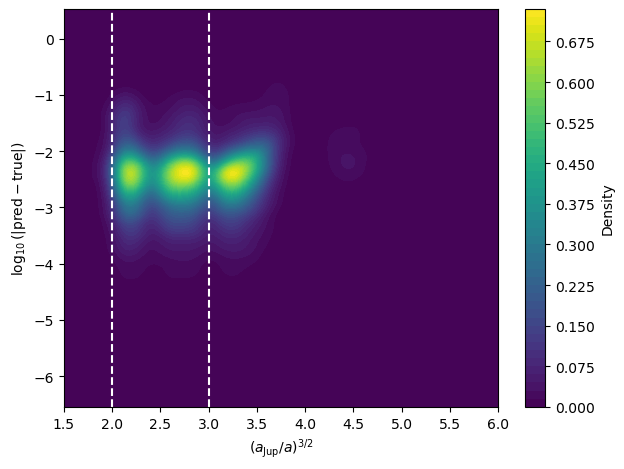

In [ ]:
from scipy.stats import gaussian_kde

# Compute your X and Y data
x = (aJup / testX['propa'])**(3/2)
y = np.log10(np.abs(pred - testY))

# Stack the data for KDE
xy = np.vstack([x, y])
kde = gaussian_kde(xy)

# Create a grid over the plot range
xgrid = np.linspace(1.5, 6, 200)
ygrid = np.linspace(np.min(y), np.max(y), 200)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde(np.vstack([Xgrid.ravel(), Ygrid.ravel()])).reshape(Xgrid.shape)

# Plot
fig, ax = plt.subplots()
contour = ax.contourf(Xgrid, Ygrid, Z, levels=50, cmap='viridis')
ax.set_xlim([1.5, 6])
ax.axvline(2, color='white', linestyle='--')
ax.axvline(3, color='white', linestyle='--')
fig.colorbar(contour, ax=ax, label='Density')
ax.set_xlabel(r'$(a_\mathrm{Jup} / a)^{3/2}$')
ax.set_ylabel(r'$\log_{10}(|\mathrm{pred} - \mathrm{true}|)$')
plt.tight_layout()
plt.show()